# HCLIM Validation 

using HCLIM to validate LMR

## Loading HCLIM data
Load .tab files and combine all surface air temperature (TA) data into one pandas dataframe


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyleoclim as pyleo
import os
import xarray as xr

In [2]:
# read all csvs and combine into one dataframe 

files = os.listdir('./datasets/')
data = []
for file in files:
    if ('_Ta' in file) and ('Tair' not in file):
        df = pd.read_csv(f'./datasets/{file}',sep='\t', skiprows=23)
        data.append(df)

df_ta = pd.concat(data)

# identify all unique station IDs
stations_id = df_ta['ID'].unique()

In [3]:
# create dictionary for all stations with lat/lon, start/end date, and length of timeseries

ta_dict = {}
for id in stations_id:
    station_data = df_ta[df_ta['ID'] == id]
    station_name = station_data['Station'].unique()[0]
    mini = station_data['Date/Time'].min()
    maxi = station_data['Date/Time'].max()
    lat = station_data['Latitude'].unique()[0]
    lon = station_data['Longitude'].unique()[0]
    length = len(station_data['TTT monthly m [°C]'].values)
    ta_dict[id] = {'Station': station_name,
                'Date min': mini,
                'Date max': maxi,
                'Length': length,
                'Latitude': lat,
                'Longitude': lon}




In [4]:
# sort to obtain all stations that have records before 1850
old_ta = []
for id in stations_id:
    val = int(ta_dict[id]['Date min'][:-3])
    if 1850 >= val:
        old_ta.append(id)

old_ta_dict = {}
for id in old_ta:
    old_ta_dict[id] = ta_dict[id]

In [5]:
# personal organization
sorted_date_dict = dict(sorted(old_ta_dict.items(), 
                         key=lambda x: x[1]['Date min']))

sorted_len_dict = dict(sorted(old_ta_dict.items(), 
                         key=lambda x: x[1]['Length'],
                         reverse = True))

### Visualizing spatial distribution of data

In [6]:
# function to extract year from specifically formatted date string 

def date_change(date_str):
    year_str, month_str = date_str.split('-')
    
    year = int(year_str)
    
    return year
    
# function to plot all stations on Robinson Projection with respect to data start year
def plot_stations(dictionary):

    df = pd.DataFrame.from_dict(dictionary, orient='index')
    
    df['date_numeric'] = df['Date min'].apply(date_change)
    
    # Create the map
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_global()
    
    scatter = ax.scatter(df['Longitude'], 
                        df['Latitude'],
                        c=df['date_numeric'],
                        transform=ccrs.PlateCarree(),  # Input coordinate system
                        cmap='magma',
                        s=20,
                        alpha=0.6,
                        zorder=5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Start Year')
    
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, alpha=0.5)
    
    plt.title('HCLIM Station Locations by Oldest Data \n(surface air temp)')
    
    return fig, ax

(<Figure size 1200x800 with 2 Axes>,
 <GeoAxes: title={'center': 'HCLIM Station Locations by Oldest Data \n(surface air temp)'}>)

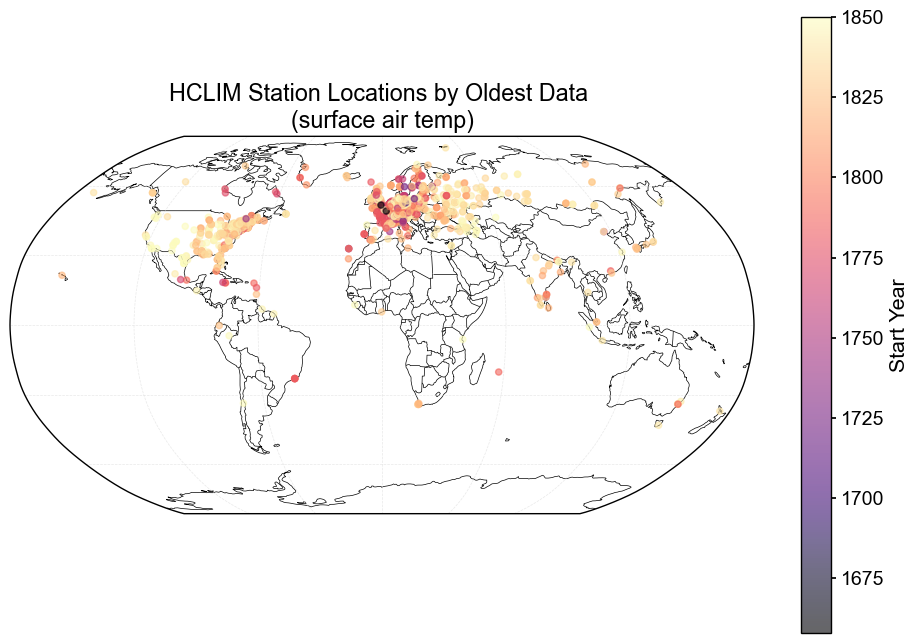

In [7]:
plot_stations(old_ta_dict)

## Loading Specific Station data (HCLIM)

### Paris
While there was a selection of close to 3000 stations in which temperaure data was recorded, Paris, specificially the EKF400 dataset has one of the longest date ranges and largest set of data points. 

In [8]:
# converting date from string to decimal format 

from datetime import datetime

def date_to_decimal_year(date_str):
    # Parse the date string
    date = datetime.strptime(date_str, '%Y-%m')
    
    # Get the year and month
    year = date.year
    month = date.month
    
    # Convert to decimal year (year + fraction of the year)
    decimal_year = year + (month - 1) / 12
    
    return decimal_year

In [9]:
# function for loading singular station data from larger dataframe with added visuals
#df is original dataframe, ID is station ID, slice_start/end are period we want to look at

def station_extraction(df, ID, slice_start, slice_end):

    #load in dataframe by ID and convert years to decimal form
    df_loc = df[df['ID']==ID]
    df_loc['Date/Time'] = df_loc['Date/Time'].apply(date_to_decimal_year)

    # get latitude and longitude
    lats = round(df_loc['Latitude'].iloc[0])
    longs = round(df_loc['Longitude'].iloc[0])

    #annualizing with same reference date range as LMR
    years = np.floor(df_loc['Date/Time'])

    loc_annual = df_loc.groupby(years)['TTT monthly m [°C]'].mean()

    ref_period_mean = loc_annual[
        (loc_annual.index >= 1951) & 
        (loc_annual.index <= 1980)
    ].mean()

    # Calculate anomalies
    loc_annual_anomalies = loc_annual - ref_period_mean
    timey = loc_annual_anomalies.index.values  
    valuey = loc_annual_anomalies.values

    loc_annual_ps = pyleo.Series(
        time=timey,
        value=valuey,
        time_name='Year',
        time_unit= 'year',
        value_name='Temperature anomaly',
        value_unit='°C'
    )

    loc_annual_slice = loc_annual_ps.sel(time=slice(slice_start, slice_end)) # not pyloclim (annual mean)

    loc_annual_ps.plot(title=f'Annualized surface air temperature at {ID}')
    loc_annual_slice.plot(title=f'Slice of above plot {ID}')

    return lats, longs, loc_annual_ps, loc_annual_slice


Time axis values sorted in ascending order


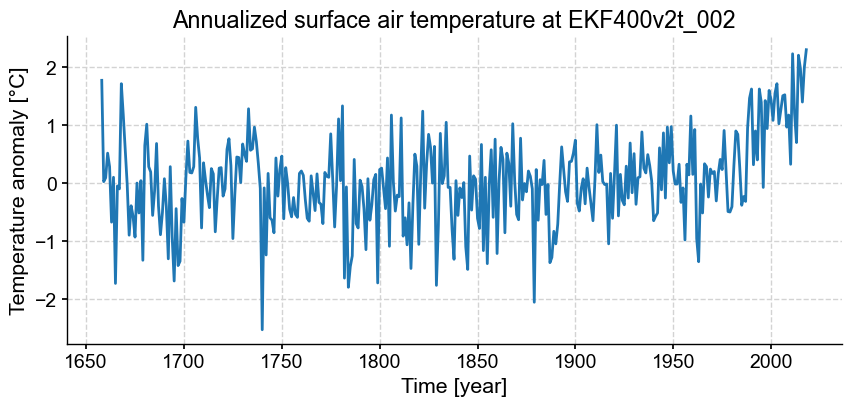

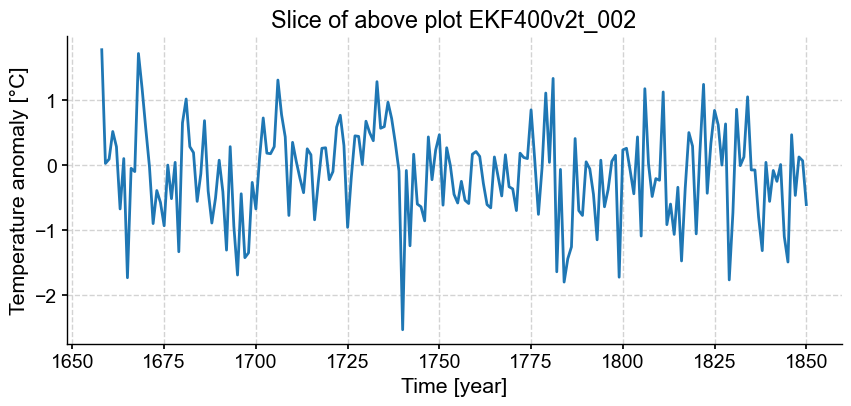

In [10]:
lat_p, long_p, paris_ps, paris_slice_ps = station_extraction(df_ta,'EKF400v2t_002',1650,1850 )

### New Haven 

Something not in Europe. You will notice this one looks worse. 

NaNs have been detected and dropped.
Time axis values sorted in ascending order


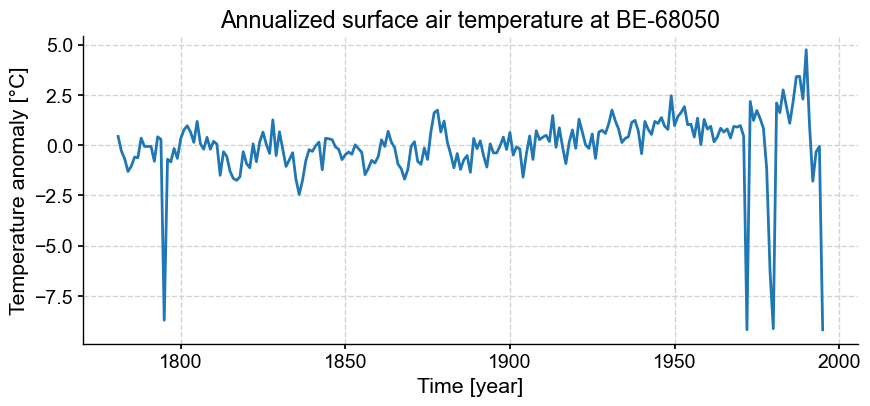

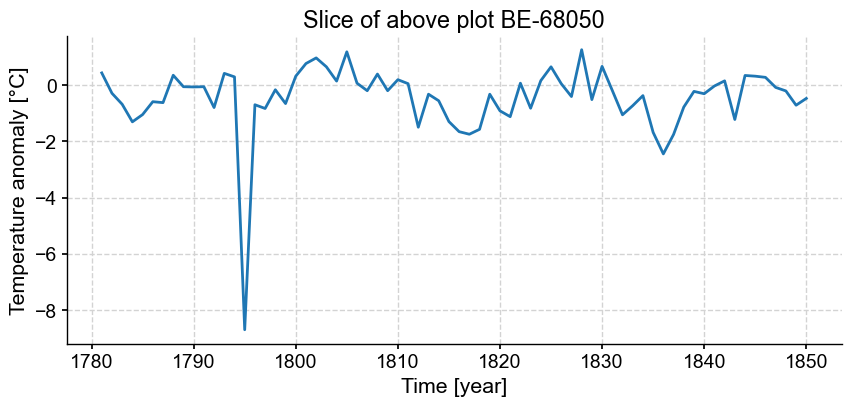

In [11]:
lat_n, long_n, nh_ps, nh_slice_ps = station_extraction(df_ta,'BE-68050', 1750,1850 )

## Loading LMRv2.1

In [12]:
# Load data using Pangeo-Forge
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1200/LMRv2p1_MCruns_ensemble_gridded.zarr"
lmr_ds_gridded = xr.open_dataset(store, engine='zarr', chunks={})
lmr_ds_gridded

<xarray.Dataset>
Dimensions:        (time: 2001, MCrun: 20, lat: 91, lon: 180)
Coordinates:
  * lat            (lat) float32 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon            (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time           (time) object 0000-01-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: MCrun
Data variables: (12/14)
    air_mean       (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    air_spread     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    hgt500_mean    (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    hgt500_spread  (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    pdsi_mean      (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    pdsi_spread    (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    ...             ...
    prate_mean     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prate_spread   (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prmsl_mean     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prmsl_spread   (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    sst_mean       (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    sst_spread     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
Attributes:
    comment:      File contains ensemble spread values for each Monte-Carlo r...
    description:  Last Millennium Reanalysis climate field reconstruction for...
    experiment:   productionFinal2_gisgpcc_ccms4_LMRdbv1.1.0_z500

In [20]:
# function to isolate lmr ensemble at specified gridpoint

def lmr_to_gridpoint(lat,lon, lmr, time_start, time_end):
    
    # get data at specified gridpoint
    grid_point_loc = lmr_ds_gridded.air_mean.isel(lat=lat, lon=lon)

# turning LMR data at Paris gridpoint into pyleo ensemble series. One for each MC iteration

    time_values_numeric = np.array([t.year for t in grid_point_loc.time.values])
    mask = (time_values_numeric >= time_start) & (time_values_numeric <= time_end)

    traces = []
    for i in range(grid_point_loc.shape[1]):
        values = grid_point_loc[mask, i].values
        
        series = pyleo.Series(
            time=time_values_numeric[mask],  # Only use times within our period
            value=values,
            time_name='Year',
            time_unit='CE',
            value_name='Air Temperature',
            value_unit='°C',
            label=f'Ensemble Member {i+1}',
            verbose=False
        )
        traces.append(series)

    # Create an EnsembleSeries object
    ensemble = pyleo.EnsembleSeries(traces)  

    return ensemble 

### Loading Paris gridpoint (LMR)
taking the closest gridpoint to our Paris HCLIM station to do a gridpoint validation 

In [21]:
ensemble_paris = lmr_to_gridpoint(lat_p, long_p, lmr_ds_gridded, 1650, 1850)

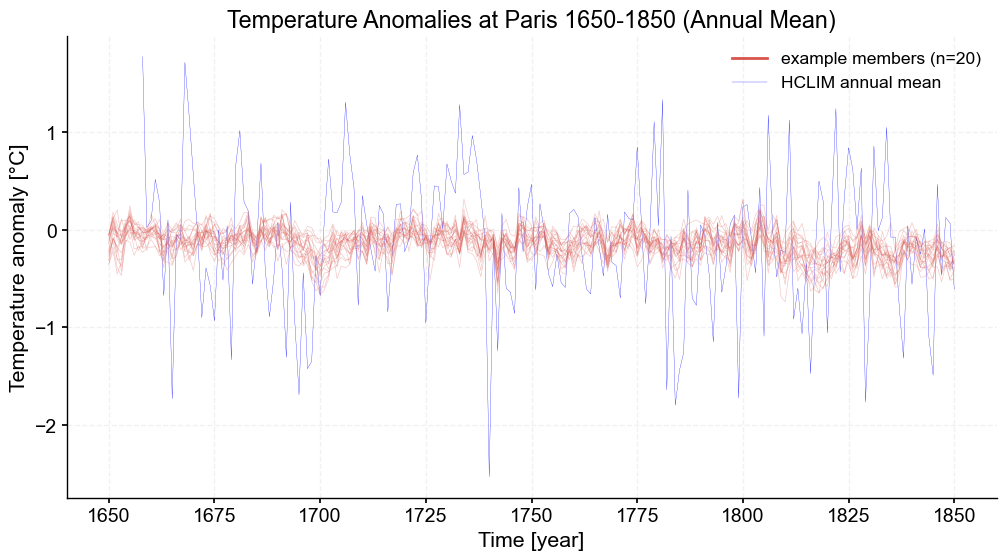

In [15]:
# Create visualization
fig, ax = ensemble_paris.plot_traces(
    num_traces=20,
    seed=42,
    figsize=(12, 6),
    lgd_kwargs = {'labels': ['MC iterations']}
)

paris_slice_ps.plot(ax=ax, linewidth=0.2, color='blue', label='HCLIM annual mean')

ax.set_title('Temperature Anomalies at Paris 1650-1850 (Annual Mean)')
ax.grid(True, alpha=0.3)
ax.legend()

### Loading New Haven gridpoint (LMR)

In [22]:
ensemble_nh = lmr_to_gridpoint(lat_n, long_n, lmr_ds_gridded, 1780,1850)

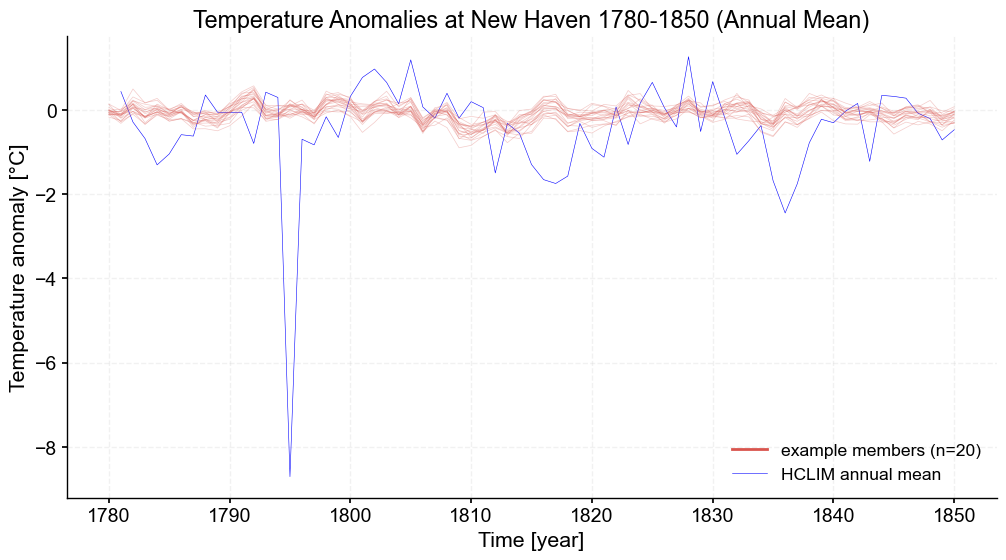

In [28]:
# Create visualization
fig, ax = ensemble_nh.plot_traces(
    num_traces=20,
    seed=42,
    figsize=(12, 6)
)

nh_slice_ps.plot(ax=ax, linewidth=0.4, color='blue', label='HCLIM annual mean')

ax.set_title('Temperature Anomalies at New Haven 1780-1850 (Annual Mean)')
ax.grid(True, alpha=0.3)
ax.legend()

## Statistics

In [23]:
def combine_spread(spread):
    return np.sqrt(np.sum(spread**2, axis=-1))

def statistics(lat, lon):
    point_data = lmr_ds_gridded.sel(lat=lat, lon=lon, method='nearest')

    # Calculate statistics (mean and spread)
    mean_temp = point_data.air_mean.mean(dim='MCrun')
    gaussian_spread = xr.apply_ufunc(
        combine_spread,
        point_data.air_spread,
        input_core_dims=[['MCrun']],
        output_core_dims=[[]],
        vectorize=True,
        dask='allowed'
    )

    # Create error bounds
    upper_bound = mean_temp + gaussian_spread
    lower_bound = mean_temp - gaussian_spread

    # Convert cftime objects to years
    years = np.array([t.year for t in point_data.time.values])

    return years, mean_temp, upper_bound, lower_bound

### Paris

In [24]:

years_paris, mean_temp_paris, upper_bound_p, lower_bound_p = statistics(lat_p, long_p)

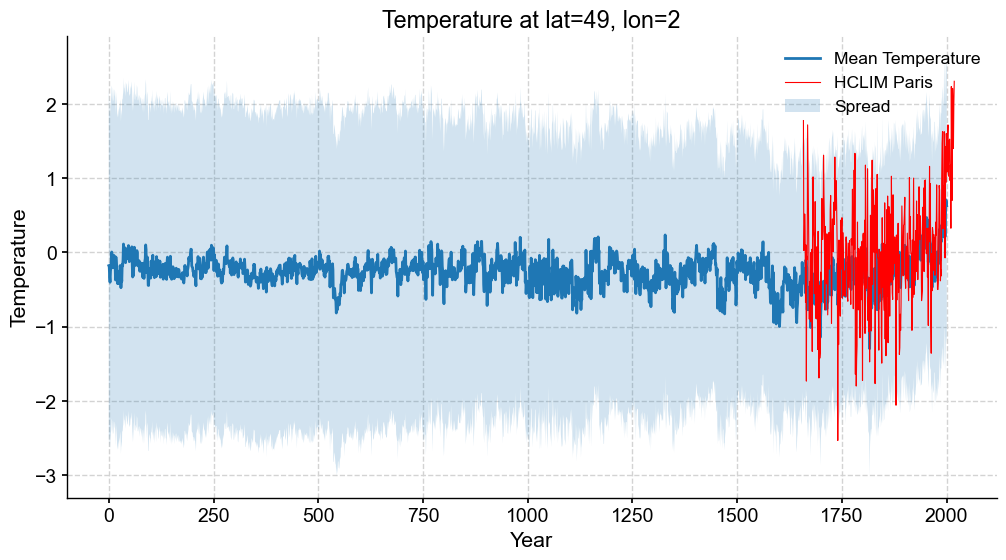

In [25]:
# Plot

plt.figure(figsize=(12, 6))
plt.plot(years_paris, mean_temp_paris, label='Mean Temperature')
plt.plot(paris_ps.time, paris_ps.value, linewidth=0.8, color='red', label='HCLIM Paris')
plt.fill_between(years_paris, lower_bound_p, upper_bound_p, alpha=0.2, label='Spread')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title(f'Temperature at lat={lat_p}, lon={long_p}')
plt.legend()
plt.grid(True)

### New Haven

In [26]:
years_nh, mean_temp_nh, upper_bound_n, lower_bound_n = statistics(lat_n, long_n)

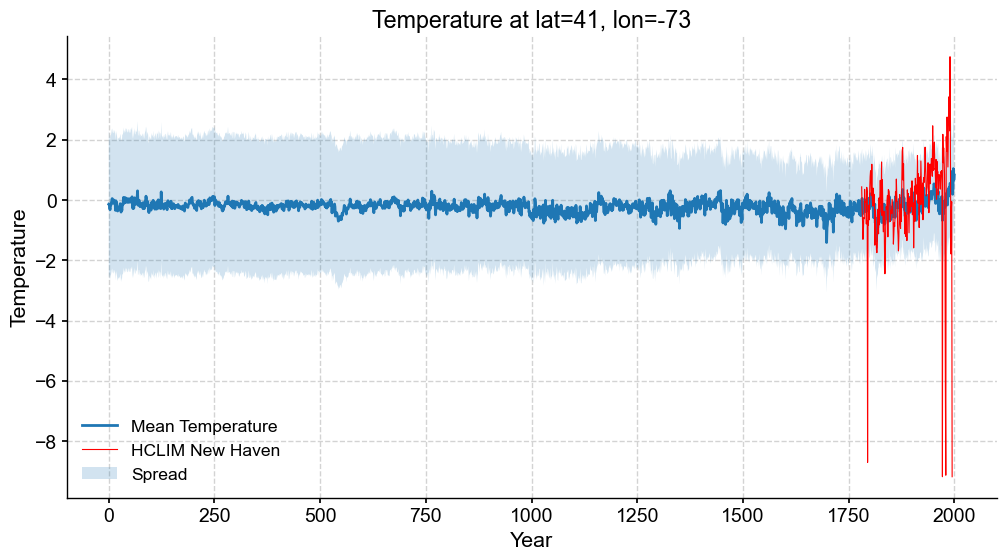

In [ ]:
# Plot
# oops this one looks bad, something is probably wrong

plt.figure(figsize=(12, 6))
plt.plot(years_nh, mean_temp_nh, label='Mean Temperature')
plt.plot(nh_ps.time, nh_ps.value, linewidth=0.8, color='red', label='HCLIM New Haven')
plt.fill_between(years_nh, lower_bound_n, upper_bound_n, alpha=0.2, label='Spread')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title(f'Temperature at lat={lat_n}, lon={long_n}')
plt.legend()
plt.grid(True)